<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 10 &ndash; Meta-Learning</h2>

<h3 style="color:rgb(0,120,170)">Exercise 1 (70 Points)</h3>
Consider the following slightly modified version of the demonstration notebook. Extend the network architecture by one additional convolutional layer with 50 input units and 50 output units and and a $5 \times 5$ kernel. This layer should use a stride of 1 and a padding of 2. Make sure to use BatchNorm analgogously to the other layers. Place the new layer between the second convolutional layer and the first fully connected layer. For this you will need to adapt the functions <code>__init__</code> and <code>forward</code> of the class <code>Net</code>. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
from IPython.display import display
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


In [4]:
class NShotKWaySampler(torch.utils.data.Sampler):
    def __init__(self, dataset, k, n, q, epoch_length):
        super(NShotKWaySampler, self).__init__(dataset)
        self.dataset = dataset
        self.num_classes = len(dataset._characters)
        self.samples_per_class = len(dataset._flat_character_images) // self.num_classes
        self.epoch_length = epoch_length
        self.n, self.k, self.q = n, k, q
    
    def __iter__(self):
        def sample(k, spc):
            r = range(k * spc, (k+1) * spc) # index range of class k in dataset
            return np.random.choice(r, size=self.n+self.q, replace=False)
        
        for _ in range(self.epoch_length):
            classes = np.random.choice(self.num_classes, size=self.k, replace=False)
            samples = np.stack([sample(k, self.samples_per_class) for k in classes])
            support, query = samples[:,:self.n], samples[:,self.n:]
            yield np.concatenate([support.flatten(), query.flatten()])

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((28, 28)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

k, n, q = 5, 1, 5

train_set = torchvision.datasets.Omniglot(root="./data", transform=transform, background=True)
train_sampler = NShotKWaySampler(train_set, k=k, n=n, q=q, epoch_length=100)
train_loader = torch.utils.data.DataLoader(train_set, batch_sampler=train_sampler)

test_set = torchvision.datasets.Omniglot(root="./data", transform=transform, background=False)
test_sampler = NShotKWaySampler(test_set, k=k, n=n, q=q, epoch_length=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_sampler=test_sampler)


In [5]:
"""adapted from https://github.com/Crisescode/pytorch-mnist/blob/master/single_cpu/model.py"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.bn1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.bn2 = nn.BatchNorm2d(50)
        
        
        self.conv3 = nn.Conv2d(50, 50, 5)
        self.bn33 = nn.BatchNorm2d(50)
        
        
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.bn3 = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 5)
    
    def forward(self, x, w):
        # we use the torch.nn.functional interface in our forward method
        x = F.conv2d(x, w['conv1.weight'], w['conv1.bias'], stride=2)
        x = F.batch_norm(x, running_mean=None, running_var=None, weight=w['bn1.weight'], bias=w['bn1.bias'], training=True)
        x = F.relu(x)
        x = F.conv2d(x, w['conv2.weight'], w['conv2.bias'], stride=2)
        x = F.batch_norm(x, running_mean=None, running_var=None, weight=w['bn2.weight'], bias=w['bn2.bias'], training=True)
        x = F.relu(x)
        
        
        x = F.conv2d(x, w['conv3.weight'], w['conv3.bias'], stride=1, padding=2)
        x = F.batch_norm(x, running_mean=None, running_var=None, weight=w['bn33.weight'], bias=w['bn33.bias'], training=True)
        x = F.relu(x)
        
        
        x = x.view(-1, 4 * 4 * 50)
        x = F.linear(x, w['fc1.weight'], w['fc1.bias'])
        x = F.batch_norm(x, running_mean=None, running_var=None, weight=w['bn3.weight'], bias=w['bn3.bias'], training=True)
        x = F.relu(x)
        x = F.linear(x, w['fc2.weight'], w['fc2.bias'])
        return x
    

training...
0.45519999988377097
0.575199999064207
0.6316000019013882
0.7028000025451183
0.7208000013232231
0.7444000005722046
0.7848000001907348
0.7952000001072883
0.7923999997973442
0.8336000007390976
0.8248000004887581
0.8263999980688095
0.8595999974012375
0.8695999985933304
0.8523999989032746
0.8575999975204468
0.8563999938964844
0.9027999955415725
0.8691999965906143
0.8887999951839447
0.8951999974250794
0.8939999961853027
0.9135999929904938
0.9027999979257584
0.8983999967575074
0.9135999953746796
0.8975999933481217
0.885999995470047
0.8847999954223633
0.8759999978542328
0.9267999958992005
0.9227999943494797
0.9147999966144562
0.9239999949932098
0.9243999940156936
0.9155999946594239
0.9255999958515168
0.9351999950408936
0.929999993443489
0.9155999970436096
0.9115999954938888
0.9447999930381775
0.9215999960899353
0.9327999973297119
0.9347999960184097
0.9423999947309494
0.9331999963521957
0.9407999938726426
0.9299999964237213
0.9079999941587448
0.9275999957323074
0.937599993944168
0.9

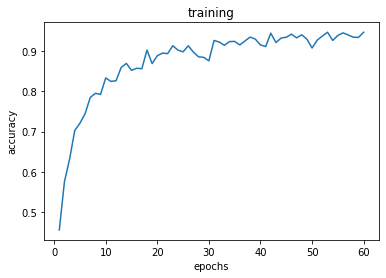

test accuracy = 0.8983999937772751 test loss = 0.29219707221724095


In [6]:
def alg(model, x, y, train, inner_steps=1, alpha=0.4):
    w = OrderedDict(model.named_parameters())
    
    for _ in range(inner_steps):
        logits = model(x, w)
        loss = F.cross_entropy(logits, y)
        grad = torch.autograd.grad(loss, w.values(), create_graph=train)
        w = OrderedDict((n, p - alpha * g) for ((n, p), g) in zip(w.items(), grad))
    
    return w

def epoch(model, loader, train):
    epoch_loss = []
    epoch_acc = []
    
    for img, _ in loader:
        s_img, q_img = img[:k*n], img[k*n:]
        w = alg(model, s_img, s_lbl, train=train)
        logits = model(q_img, w)
        loss = F.cross_entropy(logits, q_lbl)
        epoch_loss.append(loss.item())
        epoch_acc.append((logits.argmax(dim=1) == q_lbl).float().mean().item())
        
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    return np.stack(epoch_loss).mean(), np.stack(epoch_acc).mean()

# in each episode we use label indices from 0..4 instead of the ones coming from Omniglot
lbl = torch.arange(k).view((-1, 1)).repeat(1, n+q)
s_lbl, q_lbl = lbl[:,:n].flatten(), lbl[:,n:].flatten()
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print('training...')
train_accs, test_accs = [], []
num_epochs = 60

for _ in range(num_epochs):
    loss, acc = epoch(model, train_loader, train=True)
    print(acc)
    train_accs.append(acc)

loss, acc = epoch(model, test_loader, train=False)
test_accs.append(acc)

plt.title('training')
plt.plot(range(1, num_epochs + 1), train_accs)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
print('test accuracy =', acc, 'test loss =', loss)


<h3 style="color:rgb(0,120,170)">Exercise 2 (30 Points)</h3>
Implement first-order MAML. In the following lines of code you find another implementation of MAML but this time with a boolean flag named <code>second_order</code>. Adapt the function <code>alg</code> such that if <code>second_order==False</code> then first-order MAML is executed. Otherwise, second-order MAML should be executed. Test your code and compare the performance of fist-order and second-order MAML

training...
0.27680000104010105
0.2787999996542931
0.337200001552701
0.386000000089407
0.4736000002920628
0.49240000113844873
0.5199999994039536
0.5600000010430812
0.5672000017762184
0.578400001078844
0.6428000023961067
0.6528000041842461
0.6608000002801419
0.6720000045001506
0.6904000037908554
0.711600002348423
0.7212000009417534
0.7292000010609627
0.7427999988198281
0.7188000014424324
0.7416000014543533
0.7435999980568886
0.7403999996185303
0.7831999975442886
0.7480000022053719
0.7688000005483627
0.7792000013589859
0.7620000007748604
0.7783999991416931
0.7792000013589859
0.7876000028848648
0.8151999995112419
0.795199998319149
0.7832000006735325
0.8175999948382378
0.7923999989032745
0.8195999988913536
0.8139999976754189
0.8255999964475632
0.8115999999642373
0.8167999991774559
0.8036000007390975
0.8331999993324279
0.8483999994397163
0.8423999971151352
0.833999997973442
0.8216000005602837
0.8380000001192093
0.8463999989628792
0.8459999960660934
0.8443999981880188
0.8739999985694885
0.85

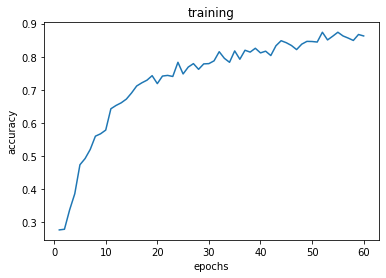

test accuracy = 0.820799998641014 test loss = 0.5440750727802515


In [9]:
def alg(model, x, y, train, second_order, inner_steps=1, alpha=0.4):
    w = OrderedDict(model.named_parameters())
    
    for _ in range(inner_steps):
        logits = model(x, w)
        loss = F.cross_entropy(logits, y)
        # HINT: modify the following line
        grad = torch.autograd.grad(loss, w.values(), create_graph=second_order) # we know that create_graph=
            # True is needed to compute higher order products; when the second_order is True then we use
            # create_graph=second_order (what is True) and the second order can be computed
            # else with create_graph=second_order (what is False) we cannot compute higher orders and therefore only
            # the first order performance
            
        w = OrderedDict((n, p - alpha * g) for ((n, p), g) in zip(w.items(), grad))
    
    return w

def epoch(model, loader, train, second_order): # outer loop which calculates the second deri.
    epoch_loss = []
    epoch_acc = []
    
    for img, _ in loader:
        s_img, q_img = img[:k*n], img[k*n:]
        w = alg(model, s_img, s_lbl, train=train, second_order=second_order)
        logits = model(q_img, w)
        loss = F.cross_entropy(logits, q_lbl)
        epoch_loss.append(loss.item())
        epoch_acc.append((logits.argmax(dim=1) == q_lbl).float().mean().item())
        
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    return np.stack(epoch_loss).mean(), np.stack(epoch_acc).mean()

# in each episode we use label indices from 0..4 instead of the ones coming from Omniglot
lbl = torch.arange(k).view((-1, 1)).repeat(1, n+q)
s_lbl, q_lbl = lbl[:,:n].flatten(), lbl[:,n:].flatten()
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print('training...')
train_accs, test_accs = [], []
num_epochs = 60

for _ in range(num_epochs):
    loss, acc = epoch(model, train_loader, train=True, second_order=False) # second_order=False, therefore, 
    # we compute the first order MAML
    print(acc)
    train_accs.append(acc)

loss, acc = epoch(model, test_loader, train=False, second_order=False) # second_order=False, therefore, 
    # we compute the first order MAML
test_accs.append(acc)

plt.title('training')
plt.plot(range(1, num_epochs + 1), train_accs)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
print('test accuracy =', acc, 'test loss =', loss)


Second order MAML: test accuracy = 0.8983999937772751 test loss = 0.29219707221724095 <br>
First order MAML:  test accuracy = 0.820799998641014  test loss = 0.5440750727802515 <br>
You can see that the second order MAML is more accurate and has a smaller test loss than the first order MAML. Nevertheless, the first order MAML is faster in computation.
